In [2]:
import pandas as pd
import string as str
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import random


housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
def fix_data(housing):
  housing['date'] = housing.date.str.extract(r"(\d{8})").astype(int)
  #housing['zipcode'] = housing.zipcode.astype(str) get_dummies instead
  housing.bedrooms = np.where(housing.bedrooms > 15,housing.bedrooms.median(),housing.bedrooms)
  return housing

housing = fix_data(housing)

In [18]:

Y = housing.price
X = housing.drop(['price'],axis=1)
X_train1, X_test1, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_train = X_train1.drop('zipcode',axis=1)
X_test = X_test1.drop('zipcode',axis=1)

weights = np.where(Y_train < 400000, 2, 1)

model = XGBRegressor()
model.fit(X_train, Y_train, sample_weight=weights)
predictions = model.predict(X_test)
scoring = Y_test - predictions



In [19]:

model.predict(fix_data(holdout).drop('zipcode',axis=1))
#holdout.drop('zipcode').head()

AttributeError: Can only use .str accessor with string values!

In [21]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_test, predictions, squared=False)


133544.58831747095

In [22]:
from sklearn.metrics import r2_score
r2_score(Y_test,predictions)

0.8738606673029911

In [23]:
#(abs(Y_test-predictions)/Y_test).quantile(.95) #Average % distance from true
#round(abs(Y_test-predictions).quantile(.95),2)

print('95% of home estimates are within', round((abs(Y_test-predictions)/Y_test).quantile(.95)*100,2), "% of their most recent value")

95% of home estimates are within 38.27 % of their most recent value


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '98024'),
  Text(1, 0, '98039'),
  Text(2, 0, '98040'),
  Text(3, 0, '98106'),
  Text(4, 0, '98166')])

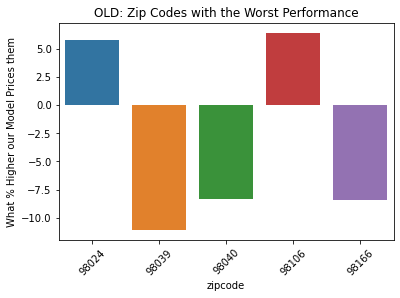

In [32]:

equality = pd.concat([(predictions-Y_test)/Y_test*100,X_test1.zipcode],axis=1).groupby('zipcode').median().reset_index()
equality['abs_price'] =equality.price.abs()
equality = equality.sort_values('abs_price',ascending=False)
# The 5 zip codes where our model most consistently underestimates 
sns.barplot(data=equality.head(),x='zipcode',y='price').set(title='OLD: Zip Codes with the Worst Performance',
                                                            ylabel='What % Higher our Model Prices them')
plt.xticks(rotation=45)



param_grid = {
    'learning_rate': [0.01, 0.05 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [5,10,15]
}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)